In [1]:
import pandas as pd
from hnmchallenge.data_reader import DataReader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from hnmchallenge.dataset import Dataset
from hnmchallenge.filtered_dataset import FilterdDataset
from hnmchallenge.models.top_pop import TopPop
from hnmchallenge.evaluation.python_evaluation import map_at_k
from hnmchallenge.constant import *

In [2]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [62]:
dataset = FilterdDataset()
dr = DataReader()

In [63]:
full_customers=dr.get_customer()

In [64]:
full_customers=full_customers.fillna(0)

In [65]:
full_customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.0,0.0,ACTIVE,NONE,24.0,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.0,0.0,ACTIVE,NONE,21.0,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0,1.0,ACTIVE,Regularly,21.0,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.0,1.0,ACTIVE,Regularly,18.0,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...


In [66]:
filtered=dr.get_filtered_new_raw_mapping_dict()

In [67]:
cust_dict, article_dict = filtered

In [68]:
cust_dict

{0: '000aa7f0dc06cd7174389e76c9e132a67860c5f65f970699daccc14425ac31a8',
 1: '001127bffdda108579e6cb16080440e89bf1250a776c6e55f56e35e9ee029a8d',
 2: '001fd23db1109a94bba1319bb73df0b479059027c182da490e1161b34cd3af61',
 3: '002b3c0a44a22c45a8d62ea9d2b88d1a89e335f8b8400335a85c3b5845794cb9',
 4: '00401a367c5ac085cb9d4b77c56f3edcabf25153615db982fcc7991d182e10a9',
 5: '00402f4463c8dc1b3ee54abfdea280e96cd87320449eca8953eb06769a5c20d4',
 6: '0051a1d00ec9a4ff1a2f9aa32a4bb054cc9ba08e80be590aec39391ff3dc56e8',
 7: '00609a1cc562140fa87a6de432bef9c9f0b936b259ad3075eb2a65008df1dbab',
 8: '008a118b7c72fd3b8a614eb2672ddfc2a78434c5776af215f4e281fa7506b842',
 9: '00a017d6e1010e117e3881be44027688795bf5f3c363696f7260d0ebe2727285',
 10: '00ac5119d21281802ecd309e8c7fa0b598e0be861f21caadefd9bc8cf3f87eed',
 11: '00b10bf5c51e961bd91f7ed9081b1bc6fc7e86000c2bed1a2d9f70da02012432',
 12: '00b1804e347ad55d1a75d7c07169e17d1890ad48953824879234177741a85955',
 13: '00c83c269bedcb5135799d3bc4a7ae6f134d57bdd1be071486ef152

In [69]:
customer_frame= pd.DataFrame.from_dict(cust_dict,orient='index')

In [70]:
customer_frame

,0
0,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...
1,001127bffdda108579e6cb16080440e89bf1250a776c6e...
2,001fd23db1109a94bba1319bb73df0b479059027c182da...
3,002b3c0a44a22c45a8d62ea9d2b88d1a89e335f8b84003...
4,00401a367c5ac085cb9d4b77c56f3edcabf25153615db9...
...,...
1136201,fee56cc5315dafb35a4490ccc6f711092cae913550c832...
1136202,ff09354db173e36e7148bd2da4da7890eaa95b00556014...
1136203,ff5b8a8b26bf93a66290e9bd1b73393ac6a58968a78519...
1136204,ff6f55a51af284b71dcd264396b299e548f968c1769e71...


In [71]:
customer_frame=customer_frame.reset_index(level=0)

In [72]:
customer_frame

,index,0
0,0,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...
1,1,001127bffdda108579e6cb16080440e89bf1250a776c6e...
2,2,001fd23db1109a94bba1319bb73df0b479059027c182da...
3,3,002b3c0a44a22c45a8d62ea9d2b88d1a89e335f8b84003...
4,4,00401a367c5ac085cb9d4b77c56f3edcabf25153615db9...
...,...,...
1136201,1136201,fee56cc5315dafb35a4490ccc6f711092cae913550c832...
1136202,1136202,ff09354db173e36e7148bd2da4da7890eaa95b00556014...
1136203,1136203,ff5b8a8b26bf93a66290e9bd1b73393ac6a58968a78519...
1136204,1136204,ff6f55a51af284b71dcd264396b299e548f968c1769e71...


In [73]:
customer_frame=customer_frame.rename(columns={0:"customer_id"})

In [74]:
customer=customer_frame.merge(full_customers,on='customer_id',how='left')

In [75]:
customer=customer.drop("customer_id",axis=1)

In [76]:
customer=customer.rename(columns={"index":"customer_id"})

In [77]:
customer

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,0.0,0.0,ACTIVE,NONE,22.0,6d98a3ca1370c33de04f4a0c2e81cd9c9e36d9501ca6dc...
1,1,0.0,0.0,ACTIVE,NONE,26.0,4845d19cdb5e363f52a5d9899ff2354fb39229c46824e4...
2,2,0.0,0.0,ACTIVE,NONE,53.0,ad36d566f461bead333901eb0f36a7fca1f86cac0e4f9f...
3,3,0.0,0.0,ACTIVE,NONE,38.0,17453ea79bc8f99f3e991b213bf26da9be55693bad8d13...
4,4,1.0,1.0,ACTIVE,Regularly,28.0,3fc82ea96449cbb089311dc2999deda150afd8496337f2...
...,...,...,...,...,...,...,...
1136201,1136201,1.0,1.0,ACTIVE,Regularly,53.0,d5b28659d67f2d3f967c0e7e3dd9653fcc737087880546...
1136202,1136202,0.0,0.0,ACTIVE,NONE,46.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
1136203,1136203,0.0,0.0,ACTIVE,NONE,19.0,19b57d8db25e3620b7fbe3a3448e39307d62f2a91c5035...
1136204,1136204,0.0,0.0,ACTIVE,NONE,22.0,c00a018625eb885cefe55cf75537079538bd242b8c9eae...


In [80]:
dr.get_filtered_articles()

AttributeError: 'DataReader' object has no attribute 'get_filtered_articles'

In [6]:
fd1 = dr1.get_filtered_full_data()

In [7]:
item_per_user1 = fd1.groupby("customer_id")["article_id"].apply(list)

In [8]:
unique_item_per_user1 = item_per_user1.apply(np.unique)

In [9]:
df_multiple1 = item_per_user1.to_frame()
df_unique1 = unique_item_per_user1.to_frame()

In [10]:
df_multiple1["count"] = df_multiple1.apply(lambda row: len(row["article_id"]), axis=1)
df_unique1["count"] = df_unique1.apply(lambda row: len(row["article_id"]), axis=1)

In [12]:
merge_df1 = pd.merge(df_multiple1, df_unique1, on="customer_id")

In [13]:
merge_df1["diff"] = 1 - (merge_df1["count_y"]/merge_df1["count_x"])

Text(0.5, 0, 'user tendency buying multiple items')

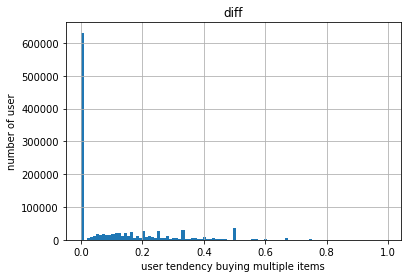

In [14]:
merge_df1.hist("diff", bins=100)
plt.ylabel("number of user")
plt.xlabel("user tendency buying multiple items")

In [15]:
merge_df1.head()

,article_id_x,count_x,article_id_y,count_y,diff
customer_id,,,,,
0,"[0, 0, 0, 644, 1952, 1952, 1482, 1638, 1797, 4...",14,"[0, 644, 1482, 1638, 1652, 1797, 1952, 4861, 7...",11,0.214286
1,"[1, 482, 759, 2006, 339, 339, 6018, 7534, 7534...",24,"[1, 339, 482, 759, 981, 1482, 2006, 2427, 2997...",21,0.125000
2,"[2, 326, 2055, 2238, 4151, 309, 5786, 5174, 54...",26,"[2, 9, 196, 248, 249, 309, 326, 2055, 2238, 30...",26,0.000000
3,"[3, 3, 3, 2596, 3936, 632, 3]",7,"[3, 632, 2596, 3936]",4,0.428571
4,[4],1,[4],1,0.000000


In [17]:
user_diff=merge_df1.drop(["article_id_x","count_x","article_id_y","count_y"], axis=1)

In [18]:
user_diff.head()

,diff
customer_id,
0,0.214286
1,0.125000
2,0.000000
3,0.428571
4,0.000000


In [23]:
user_diff.reset_index(level=0, inplace=True)

In [24]:
dr = DataReader()
transaction = dr.get_filtered_full_data()
item_per_user1 = transaction.groupby("customer_id")["article_id"].apply(list)
unique_item_per_user1 = item_per_user1.apply(np.unique)
df_multiple1 = item_per_user1.to_frame()
df_unique1 = unique_item_per_user1.to_frame()
df_multiple1["count"] = df_multiple1.apply(lambda row: len(row["article_id"]), axis=1)
df_unique1["count"] = df_unique1.apply(lambda row: len(row["article_id"]), axis=1)
merge_df1 = pd.merge(df_multiple1, df_unique1, on="customer_id")
merge_df1["diff"] = 1 - (merge_df1["count_y"]/merge_df1["count_x"])
user_diff=merge_df1.drop(["article_id_x","count_x","article_id_y","count_y"], axis=1)
user_diff.reset_index(level=0, inplace=True)
user_diff.to_feather(dr.get_preprocessed_data_path() / "filtered_split_user_multiple_buy.feather")

PermissionError: [Errno 13] Permission denied: '/home/aayush/../edoardo/hnm_data/preprocessed/filtered_split_user_multiple_buy.feather'

In [ ]:
def get_user_multiply_buy(self) -> pd.DataFrame:
    dr = DataReader()
    p = dr.get_preprocessed_data_path()
    user_diff_score = pd.read_feather(p /"filtered_split_user_multiple_buy.feather", columns=None, use_threads=True)
    return user_diff_score